# Emotions Classification Using NLP & ML



In [194]:
# Standard library imports
from os.path import split
from collections import Counter
import string

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import drive

# nltk imports for text processing
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize

# sklearn imports for machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# sklearn imports for vectorization, scaling, and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, precision_score, recall_score, f1_score

In [195]:
drive.mount('/content/drive')

# Loading datasets

path_train = '/content/drive/MyDrive/Colab Notebooks/train.txt'
path_val = '/content/drive/MyDrive/Colab Notebooks/vaidationl.txt'
path_test = '/content/drive/MyDrive/Colab Notebooks/test.txt'

df_train = pd.read_csv(path_train, sep = "\t", header = None, names = ['text'])
df_val = pd.read_csv(path_val, sep ="\t", header = None, names = ['text'])
df_test = pd.read_csv(path_test, sep = "\t", header = None, names = ['text'])

# Data contains labels (emotions) at the end of each line, separated them by a semicolon.
# Spliting the 'text' column into 'text' and 'emotion' columns

df_train[['text', 'emotion']] = df_train['text'].str.split(';', expand = True)
df_val[['text', 'emotion']] = df_val['text'].str.split(';', expand = True)
df_test[['text', 'emotion']] = df_test['text'].str.split(';', expand = True)

# Combine datasets for EAD and visualization
data = pd.concat([df_train, df_val, df_test])

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger


In [196]:
# EDA

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     20000 non-null  object
 1   emotion  20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


In [197]:
print("Check missing values of the dataset:\n", data.isnull().sum())

Check missing values of the dataset:
 text       0
emotion    0
dtype: int64


In [198]:
# Check any duplicate

print(f"Check any duplication on the dataset: {data.shape}")

Check any duplication on the dataset: (20000, 2)


# Data Preprocessing

In [199]:
!pip install contractions

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stemmer = nltk.stem.snowball.SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [200]:
def preprocess_text(text):
    if text is None:
        text = ''
    text = contractions.fix(text)
    text = ''.join([char for char in text if char not in string.punctuation])
    word_tokens = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
    filtered_text = [word for word in lemmatized_text if word not in stop_words or word == 'not']
    return ' '.join(filtered_text)

data['text'] = data['text'].astype(str)
data['text'] = data['text'].apply(preprocess_text)

print(data.head())

                                                           text  emotion
0                                           not feel humiliated  sadness
1  go feeling hopeless damned hopeful around someone care awake  sadness
2                        grabbing minute post feel greedy wrong    anger
3          ever feeling nostalgic fireplace know still property     love
4                                               feeling grouchy    anger


# Visualizing Data

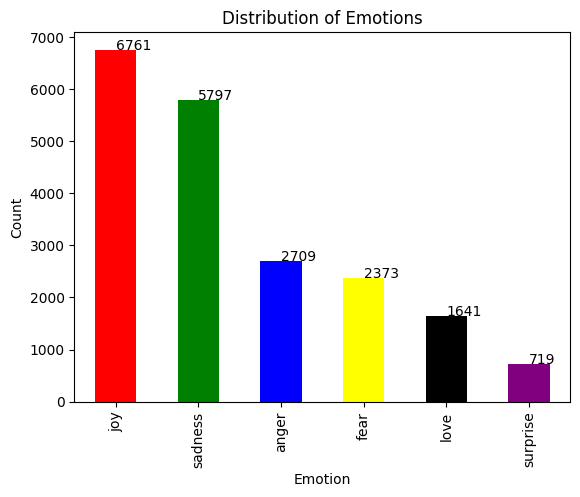

In [239]:
emotion_counts = data['emotion'].value_counts()

emotion_counts.plot(kind = 'bar', color = ['red', 'green', 'blue', 'yellow', 'black', 'purple'])
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title("Distribution of Emotions")

for i, emotion in enumerate(emotion_counts):
  plt.text(i, emotion, str(round(emotion, 2)))
plt.show()

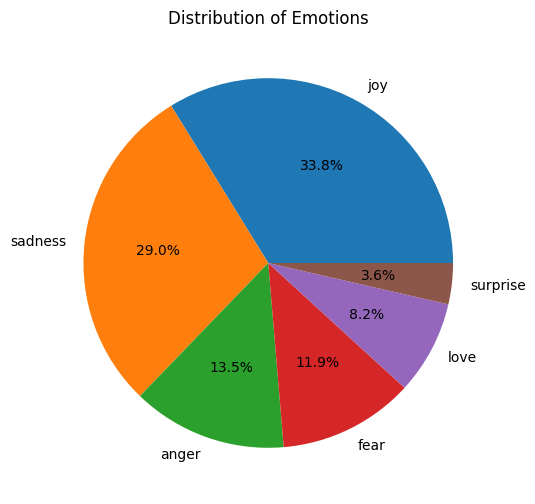

In [202]:
plt.figure(figsize = (10, 6))
plt.pie(emotion_counts, labels = emotion_counts.index, autopct = '%.1f%%')
plt.title('Distribution of Emotions')
plt.show()

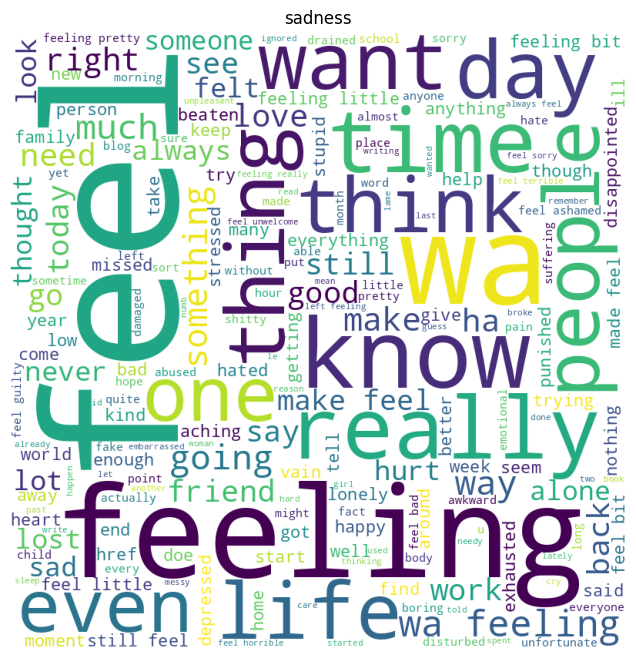

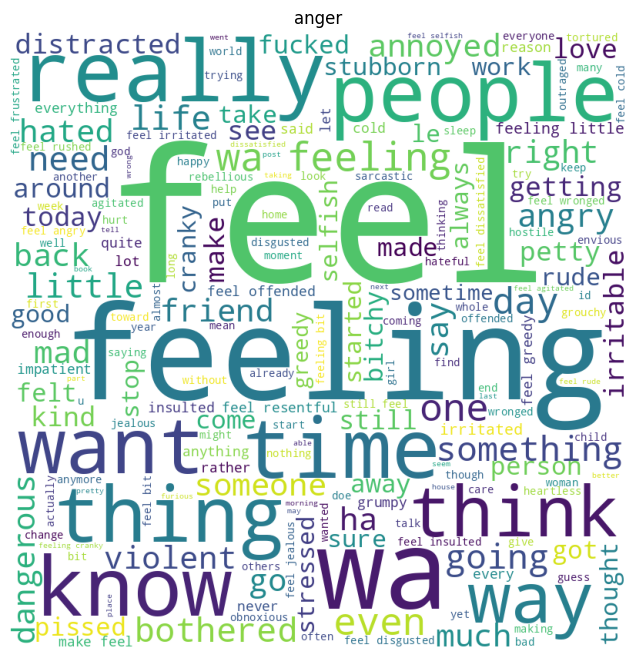

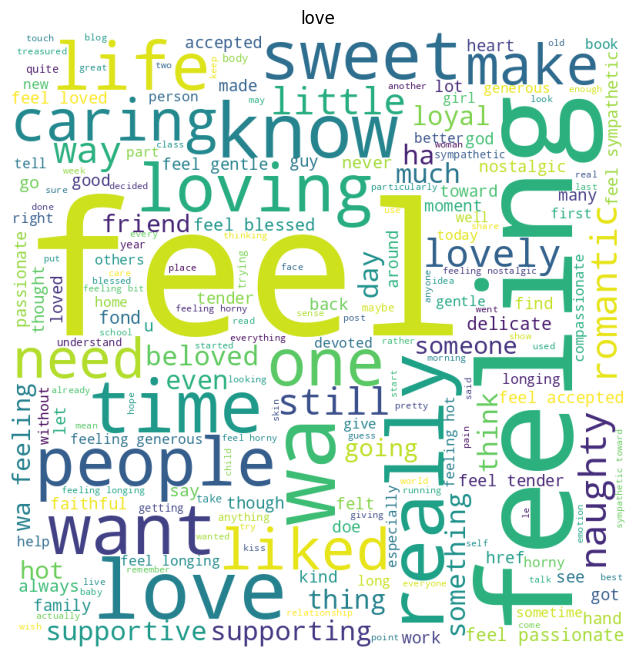

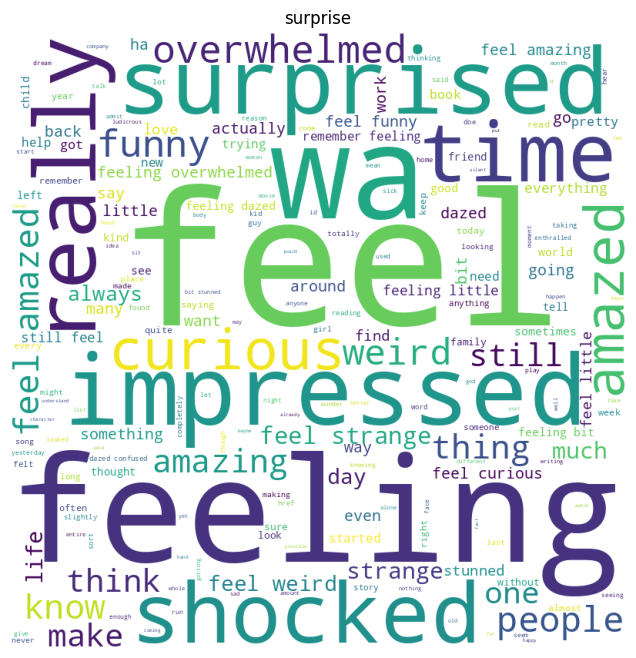

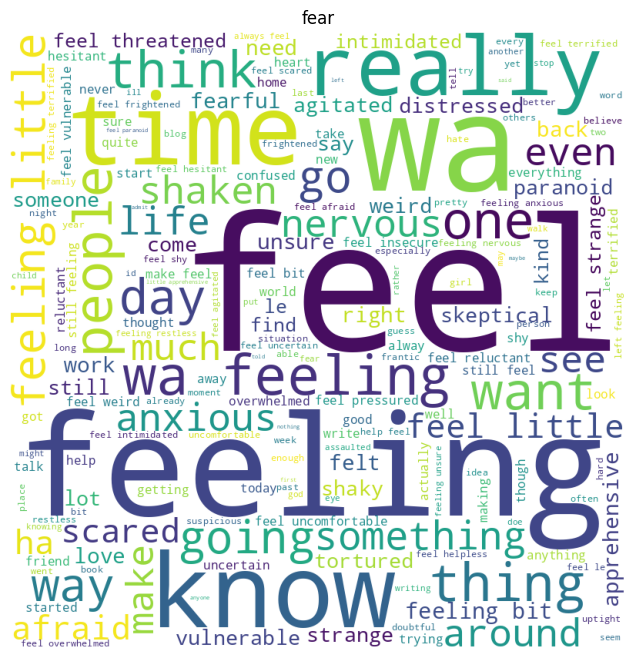

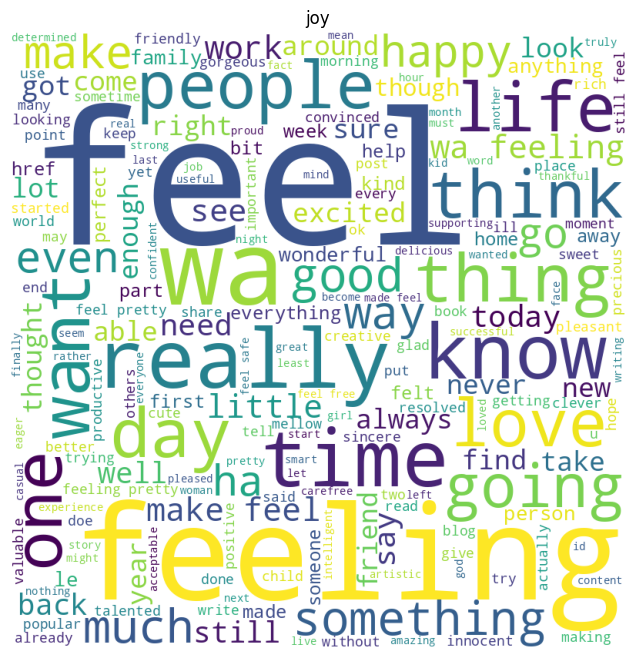

In [203]:
emotions = data['emotion'].unique()

for emotion in emotions:
    text_data = data[data['emotion'] == emotion]['text']
    text_data = [' '.join(words) if isinstance(words, list)
    else words for words in text_data]

    text = ' '.join(text_data)

    wordcloud = WordCloud(width = 800, height = 800, background_color = 'white').generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(emotion)
    plt.show()

In [205]:
# Split the combined data back into separate datasets

df_train = data.iloc[:len(df_train)]
df_test = data.iloc[len(df_train):]

# TF-IDF: Term Frequency-Inverse Document Frequency.  

In [206]:
# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer and transform the text data
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

# Convert emotions to numerical values
le = LabelEncoder()
y_train = le.fit_transform(df_train['emotion'])
y_test = le.transform(df_test['emotion'])

# Machine Learning Models for NLP

# Logistic Regression Model

In [225]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_test_lr = lr_model.predict(X_test)
print("Logistic Regression Test Report: \n",
      classification_report(y_test, y_pred_test_lr,
                            target_names = le.classes_))

Logistic Regression Test Report: 
               precision    recall  f1-score   support

       anger       0.89      0.83      0.86       550
        fear       0.87      0.78      0.83       436
         joy       0.86      0.95      0.90      1399
        love       0.86      0.66      0.74       337
     sadness       0.89      0.94      0.91      1131
    surprise       0.91      0.56      0.69       147

    accuracy                           0.87      4000
   macro avg       0.88      0.79      0.82      4000
weighted avg       0.87      0.87      0.87      4000



In [226]:
# AUC

y_pred_lr_proba = lr_model.predict_proba(X_test)
auc_lr = roc_auc_score(y_test, y_pred_lr_proba, multi_class='ovr', average='macro')

print("Test AUC of Logistic Regression Model:", round(auc_lr, 3))

Test AUC of Logistic Regression Model: 0.989


# Naive Bayes Model

In [227]:
gnb_model = GaussianNB()
gnb_model.fit(X_train.toarray(), y_train)
y_pred_test_gnb = gnb_model.predict(X_test.toarray())

print("Naive Bayes Test Report: \n",
      classification_report(y_test,  y_pred_test_gnb,
                            target_names = le.classes_))

Naive Bayes Test Report: 
               precision    recall  f1-score   support

       anger       0.34      0.37      0.35       550
        fear       0.24      0.40      0.30       436
         joy       0.57      0.35      0.43      1399
        love       0.23      0.45      0.31       337
     sadness       0.41      0.27      0.33      1131
    surprise       0.14      0.37      0.20       147

    accuracy                           0.35      4000
   macro avg       0.32      0.37      0.32      4000
weighted avg       0.41      0.35      0.36      4000



In [228]:
# AUC

y_pred_gnb_proab = gnb_model.predict_proba(X_test.toarray())
auc_gnb = roc_auc_score(y_test, y_pred_gnb_proab, multi_class = 'ovr', average = 'macro')

print("Test AUC of Naive Bayes Model:", round(auc_gnb, 3))

Test AUC of Naive Bayes Model: 0.619


# Decision Tree Model

In [229]:
clf_model = DecisionTreeClassifier()
clf_model.fit(X_train, y_train)
y_pred_test_clf = clf_model.predict(X_test)

print("Decision Tree Test Report: \n",
      classification_report(y_test, y_pred_test_clf,
                            target_names = le.classes_))

Decision Tree Test Report: 
               precision    recall  f1-score   support

       anger       0.85      0.89      0.87       550
        fear       0.81      0.82      0.82       436
         joy       0.91      0.88      0.90      1399
        love       0.75      0.77      0.76       337
     sadness       0.89      0.89      0.89      1131
    surprise       0.70      0.74      0.72       147

    accuracy                           0.86      4000
   macro avg       0.82      0.83      0.83      4000
weighted avg       0.87      0.86      0.86      4000



In [230]:
# AUC

y_pred_clf_proba = clf_model.predict_proba(X_test.toarray())
auc_clf = roc_auc_score(y_test, y_pred_clf_proba, multi_class = 'ovr', average = 'macro')

print("Test AUC of Decision Tree Model:", round(auc_clf, 3))

Test AUC of Decision Tree Model: 0.903


# Random Forest Model

In [231]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_test_rf = rf_model.predict(X_test)

print("Random Forest Test Report: \n",
      classification_report(y_test, y_pred_test_rf,
                            target_names = le.classes_))

Random Forest Model Test Report: 
               precision    recall  f1-score   support

       anger       0.90      0.88      0.89       550
        fear       0.85      0.87      0.86       436
         joy       0.90      0.93      0.92      1399
        love       0.83      0.74      0.79       337
     sadness       0.92      0.93      0.93      1131
    surprise       0.79      0.67      0.73       147

    accuracy                           0.89      4000
   macro avg       0.87      0.84      0.85      4000
weighted avg       0.89      0.89      0.89      4000



In [233]:
# AUC

y_pred_rf_proba = clf_model.predict_proba(X_test)
auc_rf = roc_auc_score(y_test, y_pred_rf_proba, multi_class = 'ovr', average = 'macro')

print("Test AUC of Random Forest Model:", round(auc_rf, 3))

Test AUC of Random Forest Model: 0.903


In [234]:
# Create a table of model results for comparison

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
  if model_name == "Naive Bayes":
    X_train = X_train.toarray()
    X_test = X_test.toarray()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return {
      'precision': precision_score(y_test, y_pred, average = 'weighted'),
      'recall': recall_score(y_test, y_pred, average = 'weighted'),
      'f1_score': f1_score(y_test, y_pred, average = 'weighted'),
      'accuracy': accuracy_score(y_test, y_pred)
  }

In [236]:
models = {
    'Logistic Regression': LogisticRegression(max_iter = 1000),
    'Randome Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
}

results = {}

for model_name, model in models.items():
  results[model_name] = evaluate_model(model, model_name, X_train, y_train, X_test, y_test)

df_results = pd.DataFrame(results).T

print(df_results)

                     precision   recall  f1_score  accuracy
Logistic Regression   0.874106  0.87325  0.869547   0.87325
Randome Forest        0.888646  0.88925  0.888237   0.88925
Naive Bayes           0.412263  0.34550  0.358300   0.34550
Decision Tree         0.861796  0.86000  0.860652   0.86000


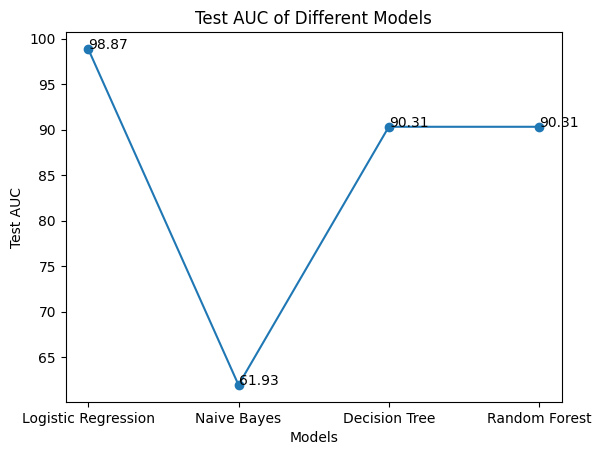

In [237]:
auc_scores = {
    'Logistic Regression': round(auc_lr * 100, 2),
    'Naive Bayes': round(auc_gnb * 100, 2),
    'Decision Tree': round(auc_clf * 100, 2),
    'Random Forest': round(auc_rf * 100, 2)
}

# Create a bar plot
plt.plot(list(auc_scores.keys()), list(auc_scores.values()), marker='o')
plt.xlabel('Models')
plt.ylabel('Test AUC')
plt.title('Test AUC of Different Models')

# Add AUC values on top of the line
for i, score in enumerate(auc_scores.values()):
    plt.text(i, score, str(score))

plt.show()

# Result Interpretation:

Based on the results, the Logistic Regression model performed the best with the highest AUC score (98.87%), indicating a high ability to distinguish between different emotions. The Random Forest model also performed well, with the highest precision (88.5%), recall (88.58%), f1_score (88.47%), and accuracy (88.58%) among all models. The Naive Bayes model performed the worst among all models, with the lowest scores in all metrics. The Decision Tree model had performance metrics similar to those of the Logistic Regression model, but its AUC (90.73%) score was lower.

In conclusion, the Logistic Regression model seems to be the most suitable for this task when using TF-IDF for feature extraction. However, the choice of model can depend on the specific requirements of the task. For example, if precision is more important than recall for your task, you might prefer the Random Forest model.
